<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Loading-and-visualizing-the-image" data-toc-modified-id="Loading-and-visualizing-the-image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading and visualizing the image</a></span></li><li><span><a href="#Segment-sand-using-Thresholding" data-toc-modified-id="Segment-sand-using-Thresholding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Segment sand using Thresholding</a></span></li><li><span><a href="#Extract-the-rocks-from-the-image" data-toc-modified-id="Extract-the-rocks-from-the-image-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Extract the rocks from the image</a></span></li><li><span><a href="#Edge-detection-for-identifying-rocks-and-bedrocks" data-toc-modified-id="Edge-detection-for-identifying-rocks-and-bedrocks-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Edge detection for identifying rocks and bedrocks</a></span></li><li><span><a href="#Segmenting-rocks-and-bedrocks-(extracting-the-shadows)" data-toc-modified-id="Segmenting-rocks-and-bedrocks-(extracting-the-shadows)-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Segmenting rocks and bedrocks (extracting the shadows)</a></span><ul class="toc-item"><li><span><a href="#KNN" data-toc-modified-id="KNN-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#Superimposing-with-contour" data-toc-modified-id="Superimposing-with-contour-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Superimposing with contour</a></span></li><li><span><a href="#Superimposing-with-KNN" data-toc-modified-id="Superimposing-with-KNN-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Superimposing with KNN</a></span></li></ul></li><li><span><a href="#Final-result-(all-3-classes)" data-toc-modified-id="Final-result-(all-3-classes)-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final result (all 3 classes)</a></span></li></ul></div>

# Load the libraries

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np
from shapely.geometry import MultiPoint
import cv2
from sklearn.cluster import KMeans
import skimage.morphology as morph
from skimage.filters import threshold_otsu
from skimage import measure
from skimage.color import label2rgb, rgb2gray

# Loading and visualizing the image

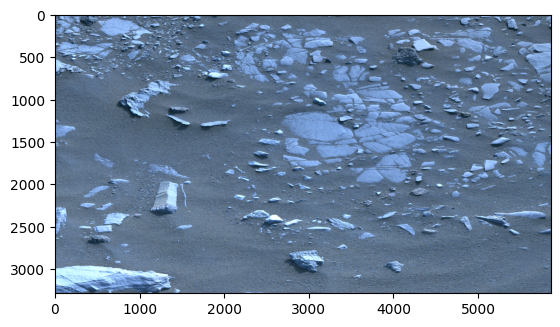

In [2]:
image = cv2.imread("images/cv_test_images_1.png")
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.show()

# Segment sand using Thresholding

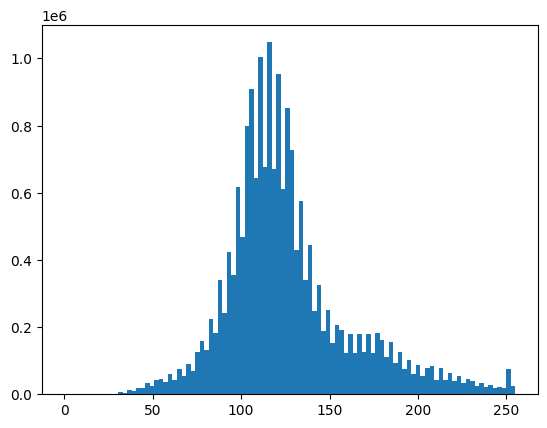

In [3]:
# plot the histogram of the image
plt.hist(img.flat, bins=100, range=(0,255));

the threshold value for segmenting sand is :  147


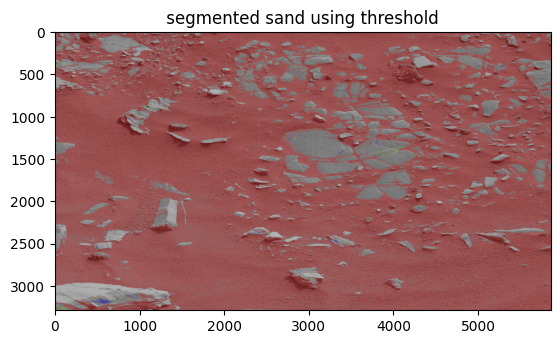

In [4]:
threshold = threshold_otsu(img)
print("the threshold value for segmenting sand is : ",threshold)
#Generate thresholded image
thresholded_img = img < threshold
# label the sand and overlap it on the original image
label_image = measure.label(thresholded_img, connectivity=img.ndim)
image_label_overlay = label2rgb(label_image, image=img)
plt.imshow(image_label_overlay)
plt.title(" segmented sand using threshold ")
plt.show()
plt.imsave("final_results/segmented_sand_using_threshold.jpg", image_label_overlay) 

# Extract the rocks from the image

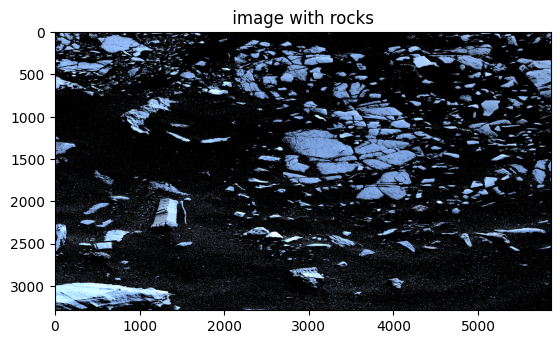

In [5]:
image_with_rocks = image.copy()
for i in range(thresholded_img.shape[0]):
    for j in range(thresholded_img.shape[1]):
        if thresholded_img[i][j] == True:
            image_with_rocks[i][j] = [0, 0, 0]
plt.imshow(image_with_rocks)
plt.title(" image with rocks ")
plt.show()

# Edge detection for identifying rocks and bedrocks

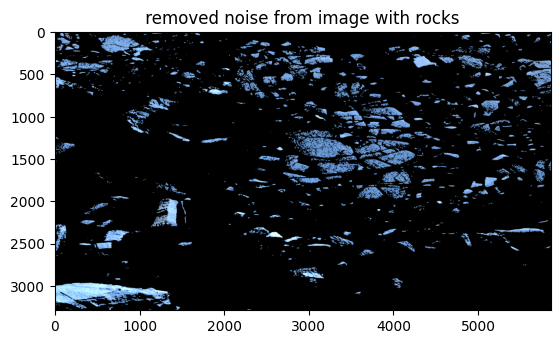

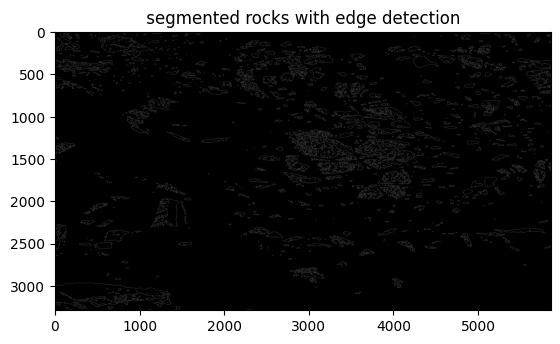

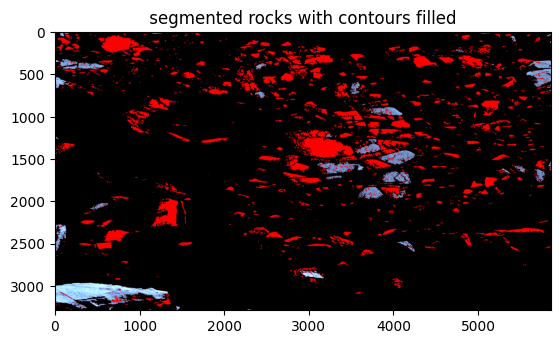

In [6]:
rock_image = image_with_rocks.copy()

# Create the erosion kernel
kernel = np.ones((5,5), np.uint8)

# Erode the image
eroded = cv2.erode(rock_image, kernel, iterations=2)
# Dilate the image
dilated = cv2.dilate(eroded,kernel, iterations=1)
plt.imshow(dilated)
plt.title(" removed noise from image with rocks ")
plt.show()

# Convert the image to grayscale
gray = cv2.cvtColor(dilated, cv2.COLOR_BGR2GRAY)

# Blur the image to reduce noise
# gray = cv2.GaussianBlur(gray, (3,3), 0)

# Define parameters for the Canny edge detector
low_threshold = 200
high_threshold = 300

# Detect edges using the Canny edge detector
edges = cv2.Canny(gray, low_threshold, high_threshold)

plt.imshow(edges, cmap="gray")
plt.title(" segmented rocks with edge detection ")
plt.show()
plt.imsave("final_results/segmented_rocks_with_edge_detection.jpg", edges) 

# Find contours in the image
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and draw and fill them with the desired color
for contour in contours:
    cv2.drawContours(dilated, [contour], 0, (255,0,0), -1)
#     cv2.drawContours(image_edges, [contour], 0, (random.randint(0,255),random.randint(0,255),random.randint(0,255)), -1)

plt.imshow(dilated)
plt.title(" segmented rocks with contours filled ")
plt.show()
plt.imsave("final_results/segmented_rocks_with_contours_filled.jpg", dilated) 

# Segmenting rocks and bedrocks (extracting the shadows)

- rocks have shadows
- bedrocks dont have shadows as they are embedded in sand

## KNN 

/home/ananya/anaconda3/envs/basic/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


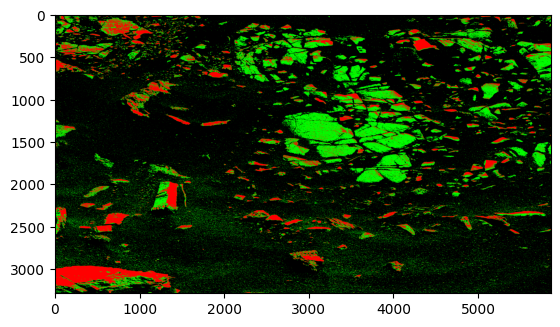

In [7]:
shadows = image_with_rocks.copy()

image = cv2.cvtColor(shadows, cv2.COLOR_BGR2RGB)

pixels = np.array(image)

(h,w,c) = image.shape
image=image.reshape((h*w,c))

kmeans=KMeans(n_clusters=3)
s=kmeans.fit_predict(image)

hh=np.array([[ 0,0  , 0],
 [0, 255, 0],
 [255, 0,0]])
rgb_cols = hh.round(0).astype(int)
img_quant = np.reshape(rgb_cols[s],(h,w,c))
segment_with_shadows = img_quant.astype(np.uint8)
plt.imshow(segment_with_shadows)
plt.show(" segmenting rocks and bedrocks with shadows ")
plt.show()
plt.imsave("final_results/segmenting_rocks_and_bedrocks_with_shadows.jpg", segment_with_shadows)

## Superimposing with contour

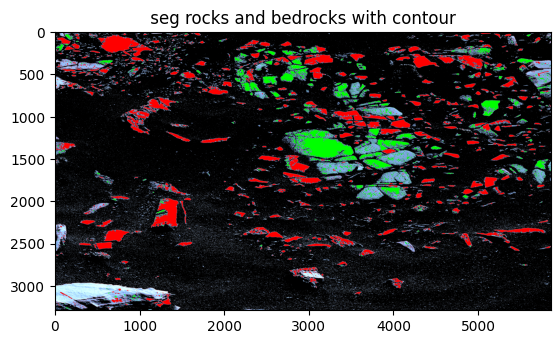

In [8]:
seg_with_contour =image_with_rocks.copy()
segment_with_shadows_gray = cv2.cvtColor(segment_with_shadows, cv2.COLOR_BGR2GRAY)

# getting contours from edge detection
for contour in contours:
    list_of_contours = []
    for val in contour:
        bounding_point = val[0]
        x = bounding_point[0]
        y = bounding_point[1]
        list_of_contours.append([x,y])
#     print(list_of_contours)

# count the pixels for rocks and bedrocks(shadows and not)
    counter_bedrock = 0
    counter_rock = 0
    for point in list_of_contours:
        if 20 < segment_with_shadows_gray[point[1]][point[0]] < 40:
            counter_bedrock +=1
        elif segment_with_shadows_gray[point[1]][point[0]] > 60:
            counter_rock += 1
    if counter_rock != 0 and counter_rock != 0:
        if counter_bedrock/counter_rock > 0.3:
            cv2.drawContours(seg_with_contour, [contour], 0, (255,0,0), -1)
        else:
            cv2.drawContours(seg_with_contour, [contour], 0, (0,255,0), -1)
    elif counter_bedrock == 0:
        cv2.drawContours(seg_with_contour, [contour], 0, (0,255,0), -1)
    elif counter_rock == 0:
        cv2.drawContours(seg_with_contour, [contour], 0, (255,0,0), -1)
            
plt.imshow(seg_with_contour)
plt.title(" seg rocks and bedrocks with contour ")
plt.show()
plt.imsave("final_results/seg_rocks_and_bedrocks_with_contour.jpg", seg_with_contour)

## Superimposing with KNN 

where the edge detector could not detect the contours, fill it with the class gotten from KNN

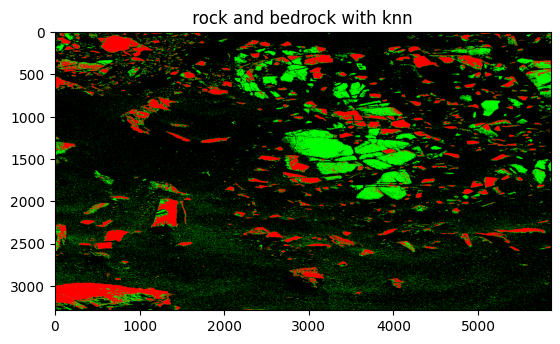

In [9]:
seg_with_knn = seg_with_contour.copy()
knn_image = segment_with_shadows.copy()

for i in range(seg_with_knn.shape[0]):
    for j in range(seg_with_knn.shape[1]):
#         print(post_process[i][j])
        if seg_with_knn[i][j][0] != 0 and seg_with_knn[i][j][1] != 0 and seg_with_knn[i][j][2] != 0:
            seg_with_knn[i][j][0] = knn_image[i][j][0]
            seg_with_knn[i][j][1] = knn_image[i][j][1]
            seg_with_knn[i][j][2] = knn_image[i][j][2]
        elif seg_with_knn[i][j][0] != 255 and seg_with_knn[i][j][1] != 0 and seg_with_knn[i][j][2] != 0:
            seg_with_knn[i][j][0] = knn_image[i][j][0]
            seg_with_knn[i][j][1] = knn_image[i][j][1]
            seg_with_knn[i][j][2] = knn_image[i][j][2]
#             print(post_process[i][j], knn_image[i][j])
        elif seg_with_knn[i][j][0] != 0 and seg_with_knn[i][j][1] != 255 and seg_with_knn[i][j][2] != 0:
            seg_with_knn[i][j][0] = knn_image[i][j][0]
            seg_with_knn[i][j][1] = knn_image[i][j][1]
            seg_with_knn[i][j][2] = knn_image[i][j][2]

plt.imshow(seg_with_knn)
plt.title(" rock and bedrock with knn ")
plt.show()
plt.imsave("final_results/rock_and_bedrock_with_knn.jpg", seg_with_knn)

# Final result (all 3 classes)

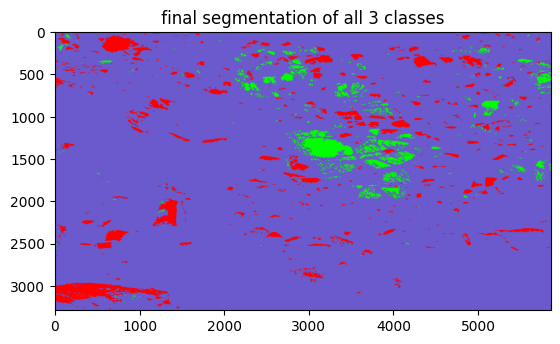

In [10]:
# Create the erosion kernel to remove noise
kernel = np.ones((5,5), np.uint8)
# Erode the image
eroded_all_classes = cv2.erode(seg_with_knn, kernel, iterations=2)
# Dilate the image
dilated_all_classes = cv2.dilate(eroded_all_classes,kernel, iterations=1)

final_seg_all_classes = dilated_all_classes.copy()
for i in range(final_seg_all_classes.shape[0]):
    for j in range(final_seg_all_classes.shape[1]):
        if final_seg_all_classes[i][j][0] == 0 and final_seg_all_classes[i][j][1] == 0 and final_seg_all_classes[i][j][2] == 0:
            #giving the class sand blue color
            final_seg_all_classes[i][j] = [106,90,205]

plt.imshow(final_seg_all_classes)
plt.title(" final segmentation of all 3 classes ")
plt.show()
plt.imsave("final_results/final_Seg_all_3_classes.jpg", final_seg_all_classes)